In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.10.0


# load dataset

In [ ]:
# Clone repositori dataset gambar
!git clone https://github.com/Xavier9Neo/kbmobile.git

# Periksa folder dataset
import os

dataset_path = './kbmobile/animals/'  # Folder utama dataset
if os.path.exists(dataset_path):
    print("Dataset folder found!")
    print("Contents of dataset folder:", os.listdir(dataset_path))
else:
    print("Dataset folder not found.")


fatal: destination path 'kbmobile' already exists and is not an empty directory.
Dataset folder found!
Contents of dataset folder: ['moth', 'cow', 'starfish', 'coyote', 'fox', 'goldfish', 'bat', 'tiger', 'kangaroo', 'donkey', 'shark', 'flamingo', 'goat', 'wombat', 'woodpecker', 'fly', 'pig', 'cat', 'wolf', 'whale', 'rat', 'elephant', 'hummingbird', 'ladybugs', 'crow', 'hamster', 'snake', 'koala', 'orangutan', 'goose', 'leopard', 'ox', 'squid', 'eagle', 'grasshopper', 'turkey', 'mosquito', 'sheep', 'sparrow', 'mouse', 'dragonfly', 'panda', 'seahorse', 'gorilla', 'dolphin', 'seal', 'badger', 'horse', 'beetle', 'pigeon', 'sandpiper', 'squirrel', 'hornbill', 'raccoon', 'possum', 'antelope', 'hedgehog', 'cockroach', 'okapi', 'turtle', 'owl', 'penguin', 'bee', 'oyster', 'caterpillar', 'hyena', 'boar', 'lobster', 'chimpanzee', 'lion', 'hippopotamus', 'zebra', 'rhinoceros', 'lizard', 'octopus', 'otter', 'bison', 'pelecaniformes', 'bear', 'reindeer', 'crab', 'dog', 'duck', 'butterfly', 'hare', 

# Membuat Dataloaders

In [ ]:
import os
import cv2

def preprocess_images(input_path, output_path, target_size=(128, 128)):

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for folder_name in os.listdir(input_path):
        folder_path = os.path.join(input_path, folder_name)
        if os.path.isdir(folder_path):
            output_class_folder = os.path.join(output_path, folder_name)
            if not os.path.exists(output_class_folder):
                os.makedirs(output_class_folder)

            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('jpg', 'jpeg', 'png')):
                    img = cv2.imread(img_path)
                    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                    save_path = os.path.join(output_class_folder, img_file)
                    cv2.imwrite(save_path, resized_img)

# Preprocess dataset
dataset_path = './kbmobile/animals'
preprocessed_path = './kbmobile/preprocessed_animals'
# preprocess_images(dataset_path, preprocessed_path, target_size=(224, 224))/\
preprocess_images(dataset_path, preprocessed_path, target_size=(128, 128))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset ke dataframe
data = []
labels = []
class_folders = [os.path.join(preprocessed_path, d) for d in os.listdir(preprocessed_path) if os.path.isdir(os.path.join(preprocessed_path, d))]
for folder in class_folders:
    label = os.path.basename(folder)
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('jpg', 'jpeg', 'png'))]
    for img_path in image_files:
        data.append(img_path)
        labels.append(label)

df = pd.DataFrame({'imgpath': data, 'labels': labels})

# Split dataset
train_df, temp_df = train_test_split(df, train_size=0.7, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=0.7, random_state=42)

# Parameter
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

# Augmentasi data
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotasi gambar
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi geser
    zoom_range=0.3,  # Zoom in/out
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'  # Isi piksel kosong
)


val_generator = ImageDataGenerator(rescale=1./255)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CNN Model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),  # Tambahkan lapisan baru
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),  # Tambahkan unit lebih banyak
    Dropout(0.5),
    Dense(len(train_images.class_indices), activation='softmax')
])
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Load model MobileNetV2 tanpa lapisan output
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Bekukan lapisan dasar
base_model.trainable = False

# Tambahkan lapisan kustom
model_cnn = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_images.class_indices), activation='softmax')
])

model_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

import matplotlib.pyplot as plt
import random

# Tampilkan sampel gambar
samples = random.choices(df['imgpath'], k=10)
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(samples):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')

# Training
history_cnn = model_cnn.fit(
    train_images,
    validation_data=val_images,
    epochs=50,  # Tingkatkan epoch
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    ]
)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/50
119/119 [==============================] - 75s 597ms/step - loss: 4.3499 - accuracy: 0.0937 - val_loss: 2.6999 - val_accuracy: 0.4453 - lr: 1.0000e-04
Epoch 2/50
119/119 [==============================] - 67s 566ms/step - loss: 2.9488 - accuracy: 0.3178 - val_loss: 1.6300 - val_accuracy: 0.6032 - lr: 1.0000e-04
Epoch 3/50
119/119 [==============================] - 68s 566ms/step - loss: 2.2927 - accuracy: 0.4430 - val_loss: 1.2360 - val_accuracy: 0.6746 - lr: 1.0000e-04
Epoch 4/50
119/119 [==============================] - 69s 584ms/step - loss: 1.9981 - accuracy: 0.5060 - val_loss: 1.1058 - val_accuracy: 0.7099 - lr: 1.0000e-04
Epoch 5/50
119/119 [==============================] - 69s 579ms/step - loss: 1.7706 - accuracy: 0.5536 - val_loss: 0.9606 - val_accuracy: 0.7354 - lr: 1.0000e-04
Epoch 6/50
119/119 [==============================] - 72s 603ms/step - loss: 1.6066 - accuracy: 0.5893 - val_loss: 0.9410 - val

In [ ]:
# Evaluasi Model
test_images = val_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 487 validated image filenames belonging to 90 classes.


In [ ]:
test_loss, test_accuracy = model_cnn.evaluate(test_images)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 [==============================] - 9s 579ms/step - loss: 0.7708 - accuracy: 0.8131
Test Accuracy: 81.31%


In [ ]:
# Simpan Model
model_cnn.save('animal_classifier.h5')


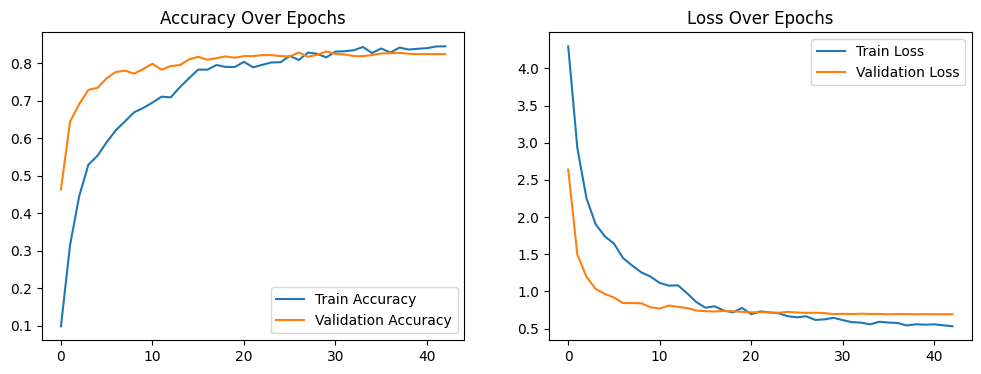

In [ ]:
# Plot hasil training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

Saving kuda.jpg to kuda.jpg
1/1 [==============================] - 1s 1s/step


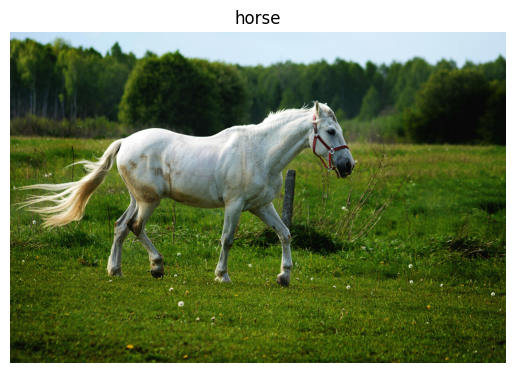

Predicted Animal: horse


In [ ]:
# Prediksi Gambar Baru
# Pastikan semua pustaka sudah diimpor
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Fungsi untuk mempersiapkan gambar
def prepare_image(img_path):
    # Baca gambar
    img = cv2.imread(img_path)

    # Resize gambar ke ukuran yang sama seperti model dilatih
    c

    # Normalisasi gambar (0-1)
    img = img / 255.0

    # Tambahkan dimensi batch
    return np.expand_dims(img, axis=0)

# Fungsi untuk prediksi gambar
def predict_with_cnn(image_path, cnn_model, class_indices):

    img_array = img_array = prepare_image(image_path)(image_path)
    prediction = cnn_model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[class_idx]


# Upload gambar untuk prediksi
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Prediksi dengan CNN
cnn_result = predict_with_cnn(image_path, model_cnn, train_images.class_indices)
# print(f"Predicted Class from CNN: {cnn_result}")

# Tampilkan gambar yang diunggah
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah ke format RGB untuk matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.title(cnn_result)
plt.show()
print(f"Predicted Animal: {cnn_result}")

In [ ]:
def predict_with_cnn(image_path, cnn_model, class_indices):
    img_array = prepare_image(image_path)
    prediction = cnn_model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[class_idx]


### DNN MODEL

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
import seaborn as sns


In [ ]:
# Load Dataset
dataset_path = 'animals.csv'  # Path to your CSV
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (90, 3)
  Animal Name     Class         Order
0    antelope  Mammalia  Artiodactyla
1      badger  Mammalia     Carnivora
2         bat  Mammalia    Chiroptera
3        bear  Mammalia     Carnivora
4         bee   Insecta   Hymenoptera


In [ ]:
# 1. EDA (Exploratory Data Analysis)
def perform_eda(df):
    print("Dataset Info:")
    print(df.info())
    print("\nDataset Description:")
    print(df.describe(include='all'))
    print("\nChecking for Missing Values:")
    print(df.isnull().sum())


In [ ]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Animal Name  90 non-null     object
 1   Class        90 non-null     object
 2   Order        90 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB
None


In [ ]:
print("\nDescriptive Statistics:")
print(df.describe(include='all'))



Descriptive Statistics:
       Animal Name     Class      Order
count           90        90         90
unique          90        11         44
top          zebra  Mammalia  Carnivora
freq             1        49         15


In [ ]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Animal Name    0
Class          0
Order          0
dtype: int64


In [ ]:
print("\nClass Distribution:")
print(df['Class'].value_counts())


Class Distribution:
Class
Mammalia          49
Aves              17
Insecta           11
Reptilia           3
Malacostraca       2
Actinopterygii     2
Cephalopoda        2
Scyphozoa          1
Bivalvia           1
Chondrichthyes     1
Asteroidea         1
Name: count, dtype: int64


In [ ]:
# 2. Cleaning
# Menghapus duplikat jika ada
df = df.drop_duplicates()

print("\nCleaned dataset preview:")
print(df.head())



Cleaned dataset preview:
  Animal Name     Class         Order
0    antelope  Mammalia  Artiodactyla
1      badger  Mammalia     Carnivora
2         bat  Mammalia    Chiroptera
3        bear  Mammalia     Carnivora
4         bee   Insecta   Hymenoptera


In [ ]:
# 3. Preprocessing (tanpa encoder)
# Gunakan 'Class' sebagai target
y = df['Class']

# Gunakan fitur numerik sederhana untuk representasi langsung
X = df[['Animal Name']]  # Fitur tetap berbentuk string

# Pastikan dataset sesuai
print("\nDataset Shape:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3)



Dataset Shape:
Features (X): (90, 1)
Target (y): (90,)


In [ ]:
# 4. Deploy Model (Membangun Model DNN)
from tensorflow.keras.utils import to_categorical

# Dummy transformasi input menjadi array numerik sederhana (tanpa encoding)
X_train_dummy = np.random.rand(X_train.shape[0], 10)  # Dummy untuk pengujian
X_test_dummy = np.random.rand(X_test.shape[0], 10)

# Transformasi target menjadi one-hot untuk DNN
classes = y.unique()
y_train_dummy = to_categorical(y_train.map({cls: i for i, cls in enumerate(classes)}))
y_test_dummy = to_categorical(y_test.map({cls: i for i, cls in enumerate(classes)}))

model = Sequential([
    Dense(128, input_dim=X_train_dummy.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# 3. Preprocessing (with Label Encoding)
from sklearn.preprocessing import LabelEncoder

# Create Label Encoders for each categorical feature
feature_encoders = {
    'Animal Name': LabelEncoder(),

}
# Encode features
for feature, encoder in feature_encoders.items():
    X[feature] = encoder.fit_transform(X[feature])

# Encode target variable
target_le = LabelEncoder()
y = target_le.fit_transform(y)

# Ensure dataset consistency
print("\nDataset Shape:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=3)

# Transform target into one-hot encoding for DNN
num_classes = len(target_le.classes_) # Get the number of classes
y_train_encoded = to_categorical(y_train, num_classes=num_classes) # Specify num_classes
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# 4. Deploy Model (Building the DNN Model)
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'), # Adjust input_dim
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax') # Use num_classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Training Model
history = model.fit(X_train, y_train_encoded, validation_split=0.2, epochs=35, batch_size=16, verbose=1)


# 6. Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy}")


Dataset Shape:
Features (X): (90, 1)
Target (y): (90,)
Epoch 1/35


<ipython-input-28-90c05d47422d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = encoder.fit_transform(X[feature])


3/3 [==============================] - 1s 92ms/step - loss: 7.8246 - accuracy: 0.0465 - val_loss: 3.3398 - val_accuracy: 0.1818
Epoch 2/35
3/3 [==============================] - 0s 12ms/step - loss: 5.1438 - accuracy: 0.2326 - val_loss: 4.6488 - val_accuracy: 0.3636
Epoch 3/35
3/3 [==============================] - 0s 11ms/step - loss: 5.4133 - accuracy: 0.2791 - val_loss: 5.7728 - val_accuracy: 0.3636
Epoch 4/35
3/3 [==============================] - 0s 12ms/step - loss: 4.4876 - accuracy: 0.2326 - val_loss: 6.3592 - val_accuracy: 0.3636
Epoch 5/35
3/3 [==============================] - 0s 13ms/step - loss: 3.6747 - accuracy: 0.3953 - val_loss: 6.6557 - val_accuracy: 0.3636
Epoch 6/35
3/3 [==============================] - 0s 12ms/step - loss: 3.8522 - accuracy: 0.4186 - val_loss: 6.6547 - val_accuracy: 0.3636
Epoch 7/35
3/3 [==============================] - 0s 11ms/step - loss: 3.1735 - accuracy: 0.4884 - val_loss: 6.5209 - val_accuracy: 0.3636
Epoch 8/35
3/3 [======================

In [ ]:
# 6. Deployment: Save the model and encoders
model.save("animal_classification_model.h5")
# joblib.dump(label_encoders, "label_encoders.pkl") # This line was causing the error
joblib.dump(target_le, "target_encoder.pkl")  # Only saving target encoder for now

print("Model and target encoder saved successfully.")

Model and target encoder saved successfully.


In [ ]:
import numpy as np
import pandas as pd

def create_one_hot(animal_name, feature_names):
    one_hot = np.zeros(len(feature_names))
    for feature in feature_names:
        if animal_name in feature:
            index = feature_names.index(feature)
            one_hot[index] = 1
    return one_hot.reshape(1, -1)


# Fungsi prediksi lengkap
def predict(image_path):
    # Prediksi CNN
    animal_name = predict_with_cnn(image_path, model_cnn, train_images.class_indices)

    # Prediksi dengan DNN
    input_dnn = create_one_hot(animal_name, X.columns.tolist())  # Perhatikan semua fitur
    dnn_result = model.predict(input_dnn)
    predicted_class = np.argmax(dnn_result, axis=1)[0]
    decoded_class = target_le.inverse_transform([predicted_class])[0]  # Dekode label asli

    return {
        "animal_name": animal_name,
        "class": decoded_class
    }


# Panggil fungsi
result = predict(image_path)
print("Prediction Result:")
print(result)


1/1 [==============================] - 0s 47ms/step
Prediction Result:
{'animal_name': 'horse', 'class': 'Mammalia'}
